In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import random

In [6]:
def dice_coeff(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

## Applying on a Single image

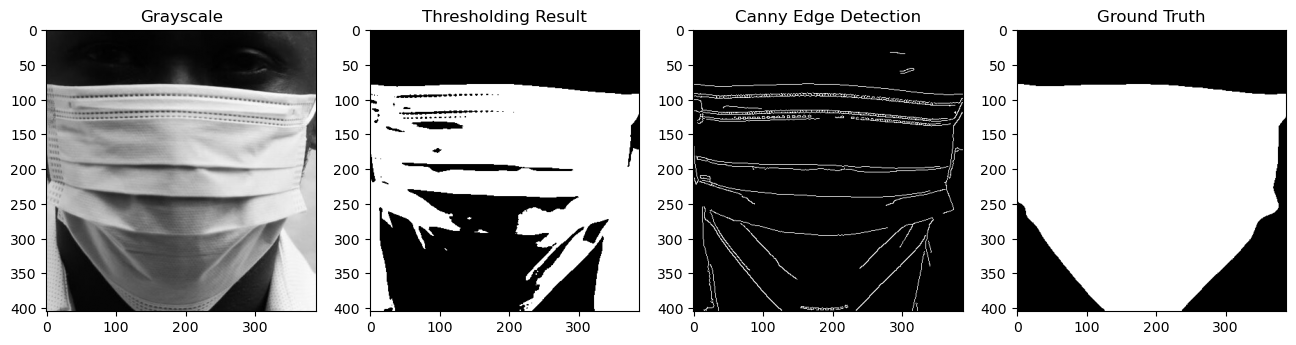

Thresholding - Dice: 0.7562, IoU: 0.6080
Canny Edge - Dice: 0.1095, IoU: 0.0579


In [7]:
image = cv2.imread("../data/MSFD/1/face_crop/000000_1.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply thresholding
thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)[1]

# Apply Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Load ground truth mask (binary)
gt_mask = cv2.imread("../data/MSFD/1/face_crop_segmentation/000000_1.jpg", 0)
gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)[1] // 255

# Convert results to binary
thresh_binary = thresh // 255
edges_binary = edges // 255

# Compute metrics for thresholding
dice_thresh = dice_coeff(gt_mask, thresh_binary)
iou_thresh = iou_score(gt_mask, thresh_binary)

# Compute metrics for Canny
dice_canny = dice_coeff(gt_mask, edges_binary)
iou_canny = iou_score(gt_mask, edges_binary)

# Display results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(gray, cmap='gray'); axes[0].set_title("Grayscale")
axes[1].imshow(thresh, cmap='gray'); axes[1].set_title("Thresholding Result")
axes[2].imshow(edges, cmap='gray'); axes[2].set_title("Canny Edge Detection")
axes[3].imshow(gt_mask, cmap='gray'); axes[3].set_title("Ground Truth")
plt.show()

# Print Dice & IoU scores
print(f"Thresholding - Dice: {dice_thresh:.4f}, IoU: {iou_thresh:.4f}")
print(f"Canny Edge - Dice: {dice_canny:.4f}, IoU: {iou_canny:.4f}")

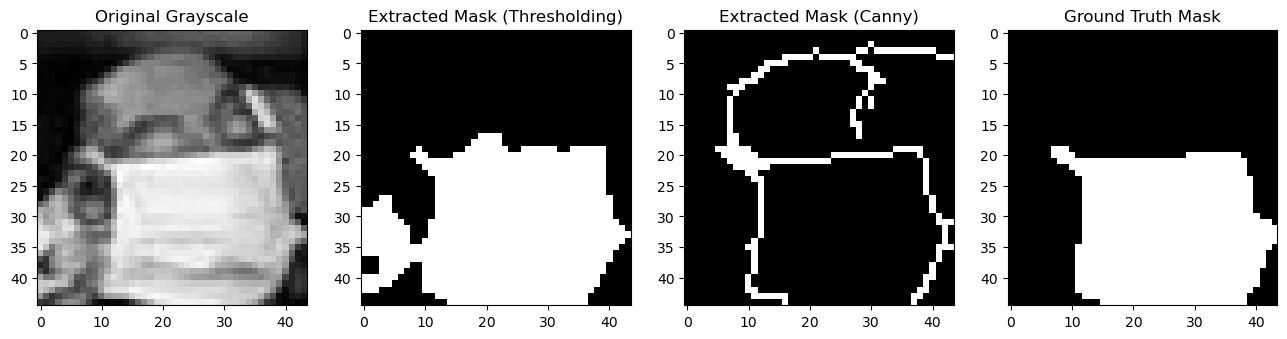

Thresholding - Dice: 0.8838, IoU: 0.7919
Canny Edge - Dice: 0.1690, IoU: 0.0923


In [8]:
image = cv2.imread("../data/MSFD/1/face_crop/000007_2.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Thresholding
_, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred, 50, 150)

# Function to extract largest contour and create a binary mask
def extract_largest_contour(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary_img)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    return mask

# Extract mask using thresholding and Canny separately
mask_thresh = extract_largest_contour(thresh)
mask_canny = extract_largest_contour(edges)

# Load ground truth mask
gt_mask = cv2.imread("../data/MSFD/1/face_crop_segmentation/000007_2.jpg", 0)
gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)[1] // 255

# Convert extracted masks to binary
mask_thresh_binary = mask_thresh // 255
mask_canny_binary = mask_canny // 255

# Compute Dice and IoU for Thresholding
dice_thresh = dice_coeff(gt_mask, mask_thresh_binary)
iou_thresh = iou_score(gt_mask, mask_thresh_binary)

# Compute Dice and IoU for Canny
dice_canny = dice_coeff(gt_mask, mask_canny_binary)
iou_canny = iou_score(gt_mask, mask_canny_binary)

# Display results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(gray, cmap='gray'); axes[0].set_title("Original Grayscale")
axes[1].imshow(mask_thresh, cmap='gray'); axes[1].set_title("Extracted Mask (Thresholding)")
axes[2].imshow(mask_canny, cmap='gray'); axes[2].set_title("Extracted Mask (Canny)")
axes[3].imshow(gt_mask, cmap='gray'); axes[3].set_title("Ground Truth Mask")
plt.show()

# Print Dice & IoU scores
print(f"Thresholding - Dice: {dice_thresh:.4f}, IoU: {iou_thresh:.4f}")
print(f"Canny Edge - Dice: {dice_canny:.4f}, IoU: {iou_canny:.4f}")



Top 3 Images with Best IoU & Dice Scores (Thresholding Method):
1. 005708_2.jpg - Dice: 0.9860, IoU: 0.9723
2. 006182_1.jpg - Dice: 0.9790, IoU: 0.9589
3. 002847_1.jpg - Dice: 0.9777, IoU: 0.9563


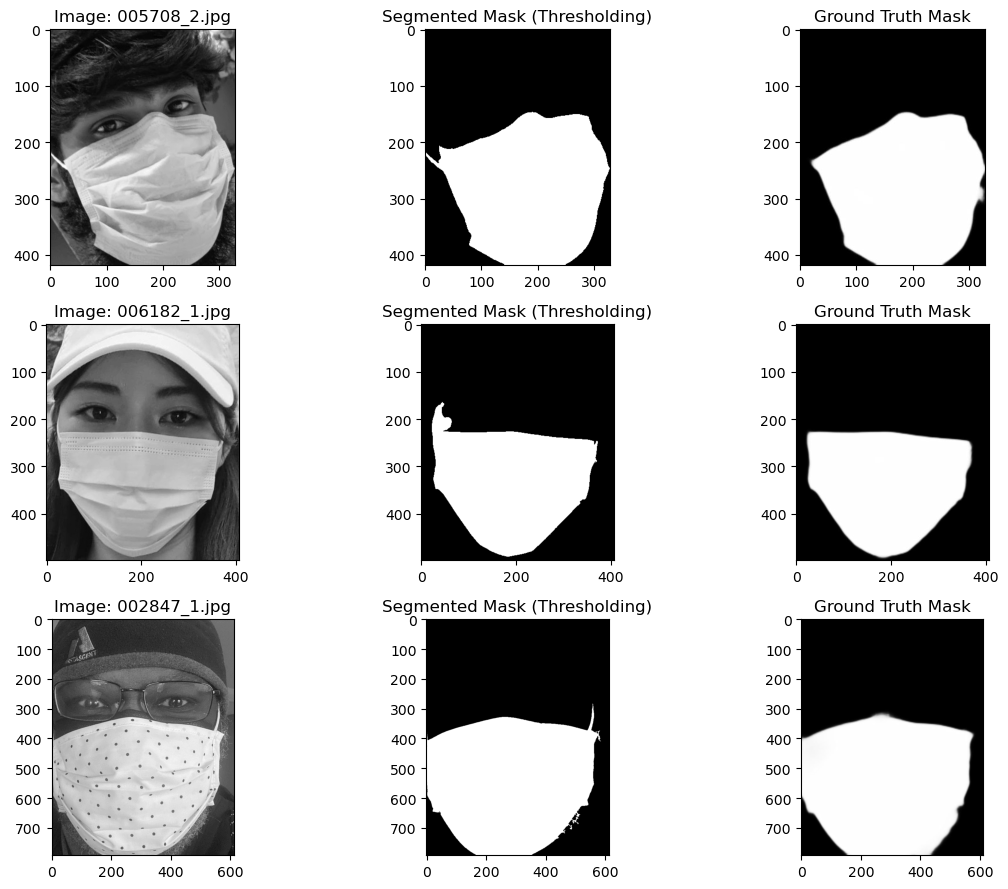

In [8]:
# Function to extract the largest contour and create a binary mask
def extract_largest_contour(binary_img, target_shape):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary_img)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Resize to match ground truth mask
    mask_resized = cv2.resize(mask, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)
    return mask_resized

# Paths to image and mask folders
image_folder = "../data/MSFD/1/face_crop/"
mask_folder = "../data/MSFD/1/face_crop_segmentation/"

# Get all image paths
image_paths = glob(os.path.join(image_folder, "*.jpg"))

# Store results
results = []

for img_path in image_paths:
    img_name = os.path.basename(img_path)
    mask_path = os.path.join(mask_folder, img_name)

    # Ensure corresponding mask exists
    if not os.path.exists(mask_path):
        continue

    # Load image and mask
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gt_mask = cv2.imread(mask_path, 0)
    gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)[1] // 255  # Convert to binary

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Thresholding
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    mask_thresh = extract_largest_contour(thresh, gt_mask.shape) // 255

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)
    mask_canny = extract_largest_contour(edges, gt_mask.shape) // 255

    # Compute Dice and IoU for Thresholding
    dice_thresh = dice_coeff(gt_mask, mask_thresh)
    iou_thresh = iou_score(gt_mask, mask_thresh)

    # Compute Dice and IoU for Canny
    dice_canny = dice_coeff(gt_mask, mask_canny)
    iou_canny = iou_score(gt_mask, mask_canny)

    # Store results
    results.append((img_name, dice_thresh, iou_thresh, dice_canny, iou_canny))

# Sort by best IoU and Dice score (Thresholding method)
results.sort(key=lambda x: (x[1] + x[2]), reverse=True)  # Sort by Dice + IoU sum

# Get top 3 images
top_3 = results[:3]

# Print top 3 images with best scores
print("\nTop 3 Images with Best IoU & Dice Scores (Thresholding Method):")
for i, (img_name, dice_thresh, iou_thresh, dice_canny, iou_canny) in enumerate(top_3):
    print(f"{i+1}. {img_name} - Dice: {dice_thresh:.4f}, IoU: {iou_thresh:.4f}")

# Display top 3 images
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, (img_name, _, _, _, _) in enumerate(top_3):
    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_folder, img_name)

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    mask_thresh = extract_largest_contour(thresh, gt_mask.shape)

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image: {img_name}")

    axes[i, 1].imshow(mask_thresh, cmap='gray')
    axes[i, 1].set_title("Segmented Mask (Thresholding)")

    axes[i, 2].imshow(gt_mask, cmap='gray')
    axes[i, 2].set_title("Ground Truth Mask")

plt.tight_layout()
plt.show()


In [9]:
# Compute average Dice and IoU scores for Thresholding and Canny methods
avg_dice_thresh = sum([r[1] for r in results]) / len(results)
avg_iou_thresh = sum([r[2] for r in results]) / len(results)
avg_dice_canny = sum([r[3] for r in results]) / len(results)
avg_iou_canny = sum([r[4] for r in results]) / len(results)

# Print results
print(f"Average Dice Score (Thresholding): {avg_dice_thresh:.4f}")
print(f"Average IoU Score (Thresholding): {avg_iou_thresh:.4f}")
print(f"Average Dice Score (Canny): {avg_dice_canny:.4f}")
print(f"Average IoU Score (Canny): {avg_iou_canny:.4f}")


Average Dice Score (Thresholding): 0.3690
Average IoU Score (Thresholding): 0.2745
Average Dice Score (Canny): 0.0494
Average IoU Score (Canny): 0.0295



Top 3 Images with Best IoU & Dice Scores (Thresholding Method):
1. 003535_1.jpg - Dice: 0.0000, IoU: 0.0000
2. 003657_1.jpg - Dice: 0.0000, IoU: 0.0000
3. 001379_1.jpg - Dice: 0.0000, IoU: 0.0000


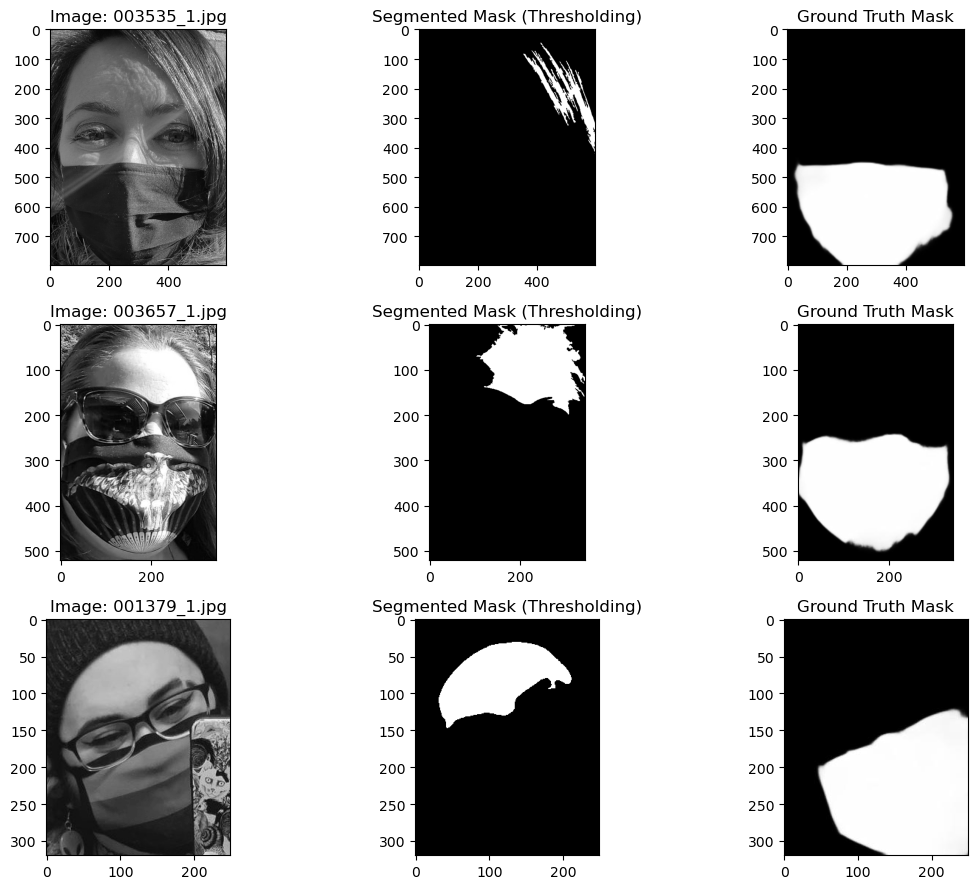

In [10]:
# Get top 3 images
top_3 = results[9000:9003]

# Print top 3 images with best scores
print("\nTop 3 Images with Best IoU & Dice Scores (Thresholding Method):")
for i, (img_name, dice_thresh, iou_thresh, dice_canny, iou_canny) in enumerate(top_3):
    print(f"{i+1}. {img_name} - Dice: {dice_thresh:.4f}, IoU: {iou_thresh:.4f}")

# Display top 3 images
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, (img_name, _, _, _, _) in enumerate(top_3):
    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_folder, img_name)

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    mask_thresh = extract_largest_contour(thresh, gt_mask.shape)

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image: {img_name}")

    axes[i, 1].imshow(mask_thresh, cmap='gray')
    axes[i, 1].set_title("Segmented Mask (Thresholding)")

    axes[i, 2].imshow(gt_mask, cmap='gray')
    axes[i, 2].set_title("Ground Truth Mask")

plt.tight_layout()
plt.show()


Top 3 Images with Best IoU & Dice Scores (Thresholding Method):
1. 002842_2.jpg - Dice: 0.9958, IoU: 0.9917
2. 003223_2.jpg - Dice: 0.9922, IoU: 0.9845
3. 004755_1.jpg - Dice: 0.9915, IoU: 0.9832


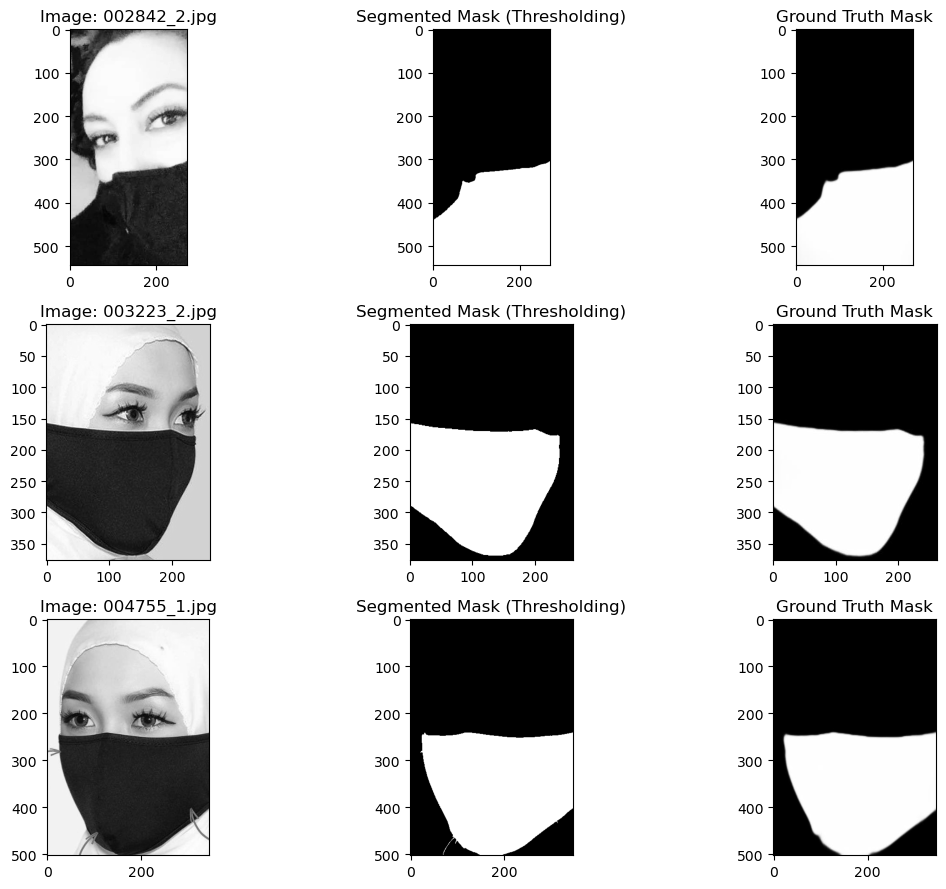

In [11]:
# Function to extract the largest contour and create a binary mask
def extract_largest_contour(binary_img, target_shape):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary_img)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Resize to match ground truth mask
    mask_resized = cv2.resize(mask, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)

    return mask_resized

# Function to select the best mask by checking white pixel density in the bottom half
def select_best_mask(mask1, mask2):
    h = mask1.shape[0]
    bottom_half_1 = np.sum(mask1[h//2:, :])  # Count white pixels in bottom half
    bottom_half_2 = np.sum(mask2[h//2:, :])

    return mask1 if bottom_half_1 >= bottom_half_2 else mask2

# Paths to image and mask folders
image_folder = "../data/MSFD/1/face_crop/"
mask_folder = "../data/MSFD/1/face_crop_segmentation/"

# Get all image paths
image_paths = glob(os.path.join(image_folder, "*.jpg"))

# Store results
results = []

for img_path in image_paths:
    img_name = os.path.basename(img_path)
    mask_path = os.path.join(mask_folder, img_name)

    if not os.path.exists(mask_path):
        continue

    # Load image and mask
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gt_mask = cv2.imread(mask_path, 0)
    gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)[1] // 255

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Thresholding
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    mask_thresh = extract_largest_contour(thresh, gt_mask.shape) // 255
    mask_thresh_inv = extract_largest_contour(cv2.bitwise_not(thresh), gt_mask.shape) // 255
    mask_thresh = select_best_mask(mask_thresh, mask_thresh_inv)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)
    mask_canny = extract_largest_contour(edges, gt_mask.shape) // 255
    mask_canny_inv = extract_largest_contour(cv2.bitwise_not(edges), gt_mask.shape) // 255
    mask_canny = select_best_mask(mask_canny, mask_canny_inv)

    # Compute Dice and IoU for Thresholding
    dice_thresh = dice_coeff(gt_mask, mask_thresh)
    iou_thresh = iou_score(gt_mask, mask_thresh)

    # Compute Dice and IoU for Canny
    dice_canny = dice_coeff(gt_mask, mask_canny)
    iou_canny = iou_score(gt_mask, mask_canny)

    # Store results
    results.append((img_name, dice_thresh, iou_thresh, dice_canny, iou_canny))

# Sort by best IoU and Dice score (Thresholding method)
results.sort(key=lambda x: (x[1] + x[2]), reverse=True)

# Get top 3 images
top_3 = results[:3]

# Print top 3 images with best scores
print("\nTop 3 Images with Best IoU & Dice Scores (Thresholding Method):")
for i, (img_name, dice_thresh, iou_thresh, dice_canny, iou_canny) in enumerate(top_3):
    print(f"{i+1}. {img_name} - Dice: {dice_thresh:.4f}, IoU: {iou_thresh:.4f}")

# Display top 3 images
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, (img_name, _, _, _, _) in enumerate(top_3):
    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_folder, img_name)

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    mask_thresh = extract_largest_contour(thresh, gt_mask.shape)
    mask_thresh_inv = extract_largest_contour(cv2.bitwise_not(thresh), gt_mask.shape)
    mask_thresh = select_best_mask(mask_thresh, mask_thresh_inv)

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image: {img_name}")

    axes[i, 1].imshow(mask_thresh, cmap='gray')
    axes[i, 1].set_title("Segmented Mask (Thresholding)")

    axes[i, 2].imshow(gt_mask, cmap='gray')
    axes[i, 2].set_title("Ground Truth Mask")

plt.tight_layout()
plt.show()



Top 3 Images with Best IoU & Dice Scores (Thresholding Method):
1. 008225_9.jpg - Dice: 0.2102, IoU: 0.1175
2. 007670_3.jpg - Dice: 0.2095, IoU: 0.1170
3. 008225_7.jpg - Dice: 0.2089, IoU: 0.1166


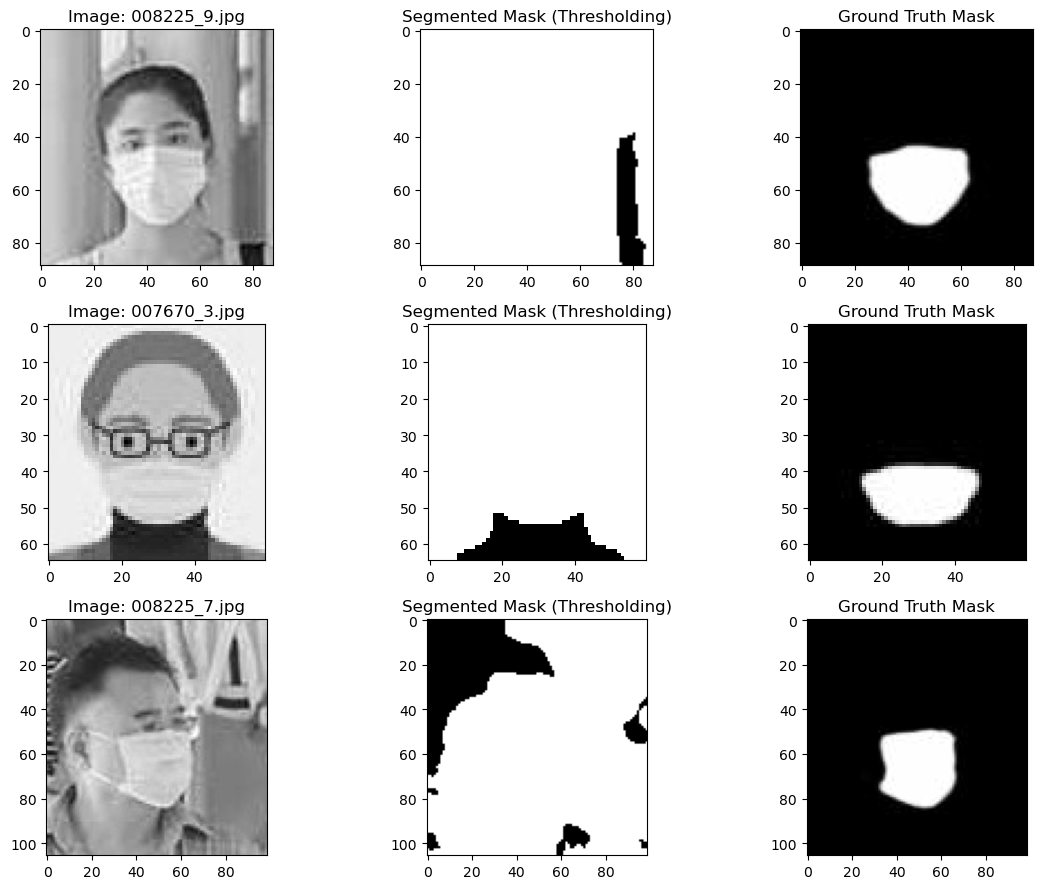

In [12]:
# Get top 3 images
top_3 = results[9073:9076]

# Print top 3 images with best scores
print("\nTop 3 Images with Best IoU & Dice Scores (Thresholding Method):")
for i, (img_name, dice_thresh, iou_thresh, dice_canny, iou_canny) in enumerate(top_3):
    print(f"{i+1}. {img_name} - Dice: {dice_thresh:.4f}, IoU: {iou_thresh:.4f}")

# Display top 3 images
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, (img_name, _, _, _, _) in enumerate(top_3):
    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_folder, img_name)

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    mask_thresh = extract_largest_contour(thresh, gt_mask.shape)
    mask_thresh_inv = extract_largest_contour(cv2.bitwise_not(thresh), gt_mask.shape)
    mask_thresh = select_best_mask(mask_thresh, mask_thresh_inv)

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image: {img_name}")

    axes[i, 1].imshow(mask_thresh, cmap='gray')
    axes[i, 1].set_title("Segmented Mask (Thresholding)")

    axes[i, 2].imshow(gt_mask, cmap='gray')
    axes[i, 2].set_title("Ground Truth Mask")

plt.tight_layout()
plt.show()


In [13]:
# Compute average Dice and IoU scores for Thresholding and Canny methods
avg_dice_thresh = sum([r[1] for r in results]) / len(results)
avg_iou_thresh = sum([r[2] for r in results]) / len(results)
avg_dice_canny = sum([r[3] for r in results]) / len(results)
avg_iou_canny = sum([r[4] for r in results]) / len(results)

# Print results
print(f"Average Dice Score (Thresholding): {avg_dice_thresh:.4f}")
print(f"Average IoU Score (Thresholding): {avg_iou_thresh:.4f}")
print(f"Average Dice Score (Canny): {avg_dice_canny:.4f}")
print(f"Average IoU Score (Canny): {avg_iou_canny:.4f}")


Average Dice Score (Thresholding): 0.5903
Average IoU Score (Thresholding): 0.4427
Average Dice Score (Canny): 0.4893
Average IoU Score (Canny): 0.3299


In [14]:
# Paths to image and mask folders
image_folder = "../data/MSFD/1/face_crop/"
mask_folder = "../data/MSFD/1/face_crop_segmentation/"

# Get all image paths
image_paths = glob(os.path.join(image_folder, "*.jpg"))

# Store results
baseline_results = []

for img_path in image_paths:
    img_name = os.path.basename(img_path)
    mask_path = os.path.join(mask_folder, img_name)

    if not os.path.exists(mask_path):
        continue

    # Load ground truth mask
    gt_mask = cv2.imread(mask_path, 0)
    gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)[1] // 255

    # Create a baseline mask: Top half black, bottom half as ground truth
    h, w = gt_mask.shape
    baseline_mask = np.zeros_like(gt_mask)
    baseline_mask[h//2:, :] = np.ones_like(gt_mask[h//2:, :])

    # Compute Dice and IoU for the baseline
    dice_baseline = dice_coeff(gt_mask, baseline_mask)
    iou_baseline = iou_score(gt_mask, baseline_mask)

    # Store results
    baseline_results.append((img_name, dice_baseline, iou_baseline))

# Compute average Dice and IoU scores
avg_dice = np.mean([res[1] for res in baseline_results])
avg_iou = np.mean([res[2] for res in baseline_results])

print(f"\nBaseline Scores with Top Half Black & Bottom Half Segmented:")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")



Baseline Scores with Top Half Black & Bottom Half Segmented:
Average Dice Score: 0.7287
Average IoU Score: 0.5863



Baseline Scores with Top Half Black & Bottom Half Segmented (Central 80% Only):
Average Dice Score: 0.7781
Average IoU Score: 0.6480


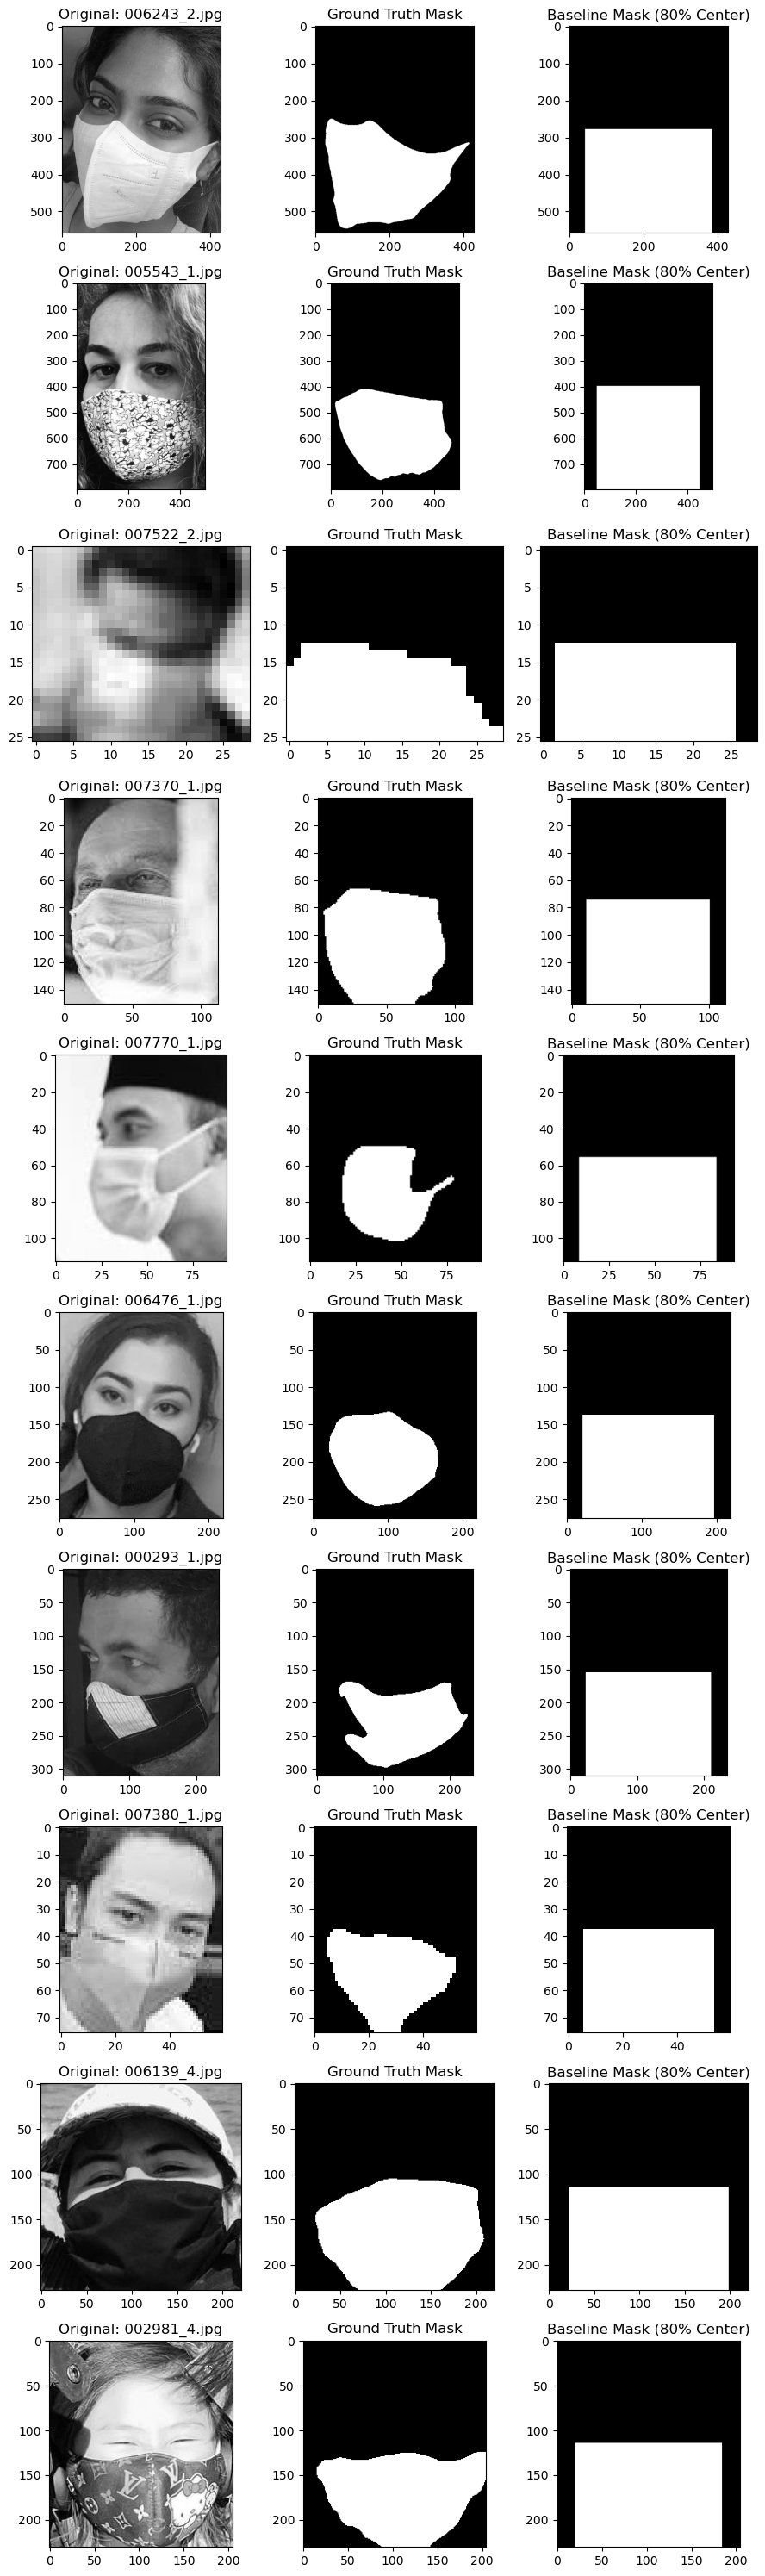

In [16]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

def dice_coeff(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-6)

# Paths to image and mask folders
image_folder = "../data/MSFD/1/face_crop/"
mask_folder = "../data/MSFD/1/face_crop_segmentation/"

# Get all image paths
image_paths = glob(os.path.join(image_folder, "*.jpg"))

# Store results
baseline_results = []
selected_images = random.sample(image_paths, 10)  # Select 10 random images

for img_path in image_paths:
    img_name = os.path.basename(img_path)
    mask_path = os.path.join(mask_folder, img_name)

    if not os.path.exists(mask_path):
        continue

    # Load ground truth mask
    gt_mask = cv2.imread(mask_path, 0)
    gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)[1] // 255

    # Get image dimensions
    h, w = gt_mask.shape
    left_margin = int(0.1 * w)  # 10% margin from left
    right_margin = int(0.9 * w)  # 90% width (removing 10% from right)

    # Create a baseline mask with top half black and bottom half white (central 80% only)
    baseline_mask = np.zeros_like(gt_mask)
    baseline_mask[h//2:, left_margin:right_margin] = 1  # Set bottom half of central 80% to white

    # Compute Dice and IoU for the baseline
    dice_baseline = dice_coeff(gt_mask, baseline_mask)
    iou_baseline = iou_score(gt_mask, baseline_mask)

    # Store results
    baseline_results.append((img_name, dice_baseline, iou_baseline))

# Compute average Dice and IoU scores
avg_dice = np.mean([res[1] for res in baseline_results])
avg_iou = np.mean([res[2] for res in baseline_results])

print(f"\nBaseline Scores with Top Half Black & Bottom Half Segmented (Central 80% Only):")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")

# Display 10 sample images
fig, axes = plt.subplots(10, 3, figsize=(9, 30))

for i, img_path in enumerate(selected_images):
    img_name = os.path.basename(img_path)
    mask_path = os.path.join(mask_folder, img_name)

    if not os.path.exists(mask_path):
        continue

    # Load ground truth mask
    gt_mask = cv2.imread(mask_path, 0)
    gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)[1]

    # Get image dimensions
    h, w = gt_mask.shape
    left_margin = int(0.1 * w)  # 10% margin from left
    right_margin = int(0.9 * w)  # 90% width (removing 10% from right)

    # Create baseline mask (central 80% only)
    baseline_mask = np.zeros_like(gt_mask)
    baseline_mask[h//2:, left_margin:right_margin] = 255  # Bottom half white in central 80%

    # Load original image
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Original: {img_name}")

    axes[i, 1].imshow(gt_mask, cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")

    axes[i, 2].imshow(baseline_mask, cmap='gray')
    axes[i, 2].set_title("Baseline Mask (80% Center)")

plt.tight_layout()
plt.show()
